# Coding Variational AutoEncoder (VAE) from scratch
<img src="https://imgs.search.brave.com/SE69rJVzCjczucyHc1vaErHcnJCxq57ETNz_-DP6kuA/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9sZWFy/bm9wZW5jdi5jb20v/d3AtY29udGVudC91/cGxvYWRzLzIwMjAv/MTEvdmFlLWRpYWdy/YW0tMS0xMDI0eDU2/My5qcGc">

## Import libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


## Load MNIST dataset

In [3]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="/.data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 60000
Test samples: 10000


## Define the Variational AutoEncoder model

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

## Instantiate model and optimizer

In [6]:
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Define the loss function
Evidence Lower BOund (ELBO) Loss = Reconstruction Loss + KL Divergence

In [7]:
def criterion(x_hat, x, mu, logvar):
    x = x.view(x.size(0), -1)
    x_hat = x_hat.view(x_hat.size(0), -1)

    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

## Training loop

In [8]:
def train_epoch(epoch):
    model.train()
    total_loss = total_recon = total_kl = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss, recon, kl = criterion(x_hat, x, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

    n = len(train_dataset)
    print(f"Epoch {epoch:02d} | Loss {total_loss/n:.4f} | Recon {total_recon/n:.4f} | KL {total_kl/n:.4f}")

def test_epoch(epoch):
    model.eval()
    total_loss = total_recon = total_kl = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            loss, recon, kl = criterion(x_hat, x, mu, logvar)

            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()

    n = len(test_dataset)
    print(f"[Test] Loss {total_loss/n:.4f} | Recon {total_recon/n:.4f} | KL {total_kl/n:.4f}")

## Train the model

In [9]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train_epoch(epoch)
    test_epoch(epoch)

Epoch 01 | Loss 189.9129 | Recon 184.1695 | KL 5.7434
[Test] Loss 171.7537 | Recon 166.4288 | KL 5.3249
Epoch 02 | Loss 169.1867 | Recon 163.8974 | KL 5.2894
[Test] Loss 165.7192 | Recon 160.0547 | KL 5.6646
Epoch 03 | Loss 164.7690 | Recon 159.3501 | KL 5.4189
[Test] Loss 163.0013 | Recon 157.6735 | KL 5.3278
Epoch 04 | Loss 162.1233 | Recon 156.6494 | KL 5.4739
[Test] Loss 160.9152 | Recon 155.3963 | KL 5.5188
Epoch 05 | Loss 160.3582 | Recon 154.8283 | KL 5.5299
[Test] Loss 159.3037 | Recon 153.5880 | KL 5.7157
Epoch 06 | Loss 159.0289 | Recon 153.4288 | KL 5.6000
[Test] Loss 158.4282 | Recon 152.5313 | KL 5.8969
Epoch 07 | Loss 157.8961 | Recon 152.2433 | KL 5.6528
[Test] Loss 157.7923 | Recon 152.0714 | KL 5.7209
Epoch 08 | Loss 156.9510 | Recon 151.2769 | KL 5.6740
[Test] Loss 157.1660 | Recon 151.4227 | KL 5.7433
Epoch 09 | Loss 156.2043 | Recon 150.4851 | KL 5.7192
[Test] Loss 156.2471 | Recon 150.5433 | KL 5.7038
Epoch 10 | Loss 155.5275 | Recon 149.7729 | KL 5.7546
[Test] Los

## Visualize reconstructions

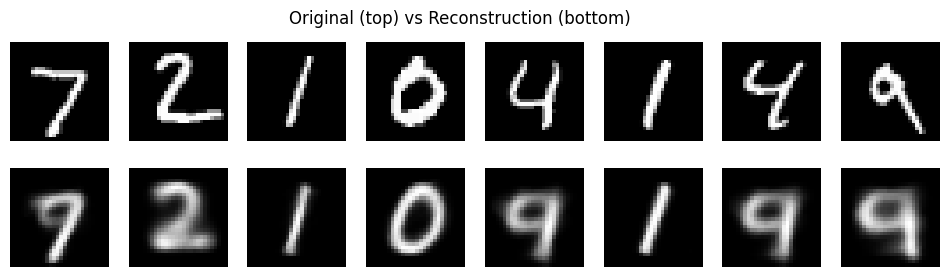

In [10]:
def show_reconstructions():
    model.eval()
    x, _ = next(iter(test_loader))
    x = x.to(device)

    with torch.no_grad():
        x_hat, _, _ = model(x)

    x = x.cpu().numpy()
    x_hat = x_hat.cpu().numpy()

    n = 8
    plt.figure(figsize=(12, 3))

    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(x[i][0], cmap="gray")
        plt.axis("off")

        plt.subplot(2, n, n+i+1)
        plt.imshow(x_hat[i][0], cmap="gray")
        plt.axis("off")

    plt.suptitle("Original (top) vs Reconstruction (bottom)")
    plt.show()

show_reconstructions()

## Plot 2D latent space

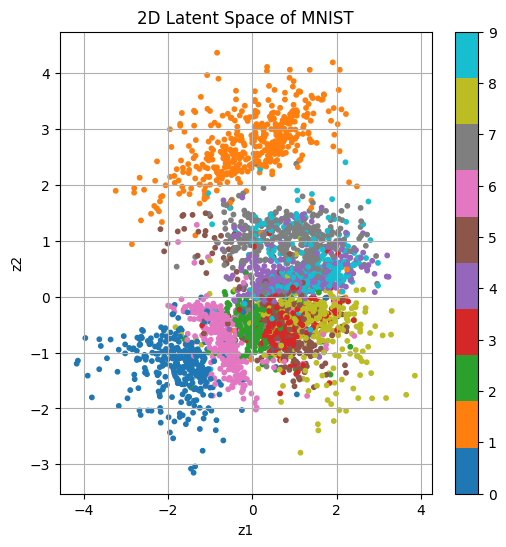

In [11]:
def plot_latent_space(num_batches=30):
    model.eval()
    zs, labels = [], []

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            if i >= num_batches:
                break
            x = x.to(device)
            mu, _ = model.encode(x)
            zs.append(mu.cpu().numpy())
            labels.append(y.numpy())

    zs = np.concatenate(zs, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(zs[:, 0], zs[:, 1], c=labels, cmap="tab10", s=10)
    plt.colorbar(scatter)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.title("2D Latent Space of MNIST")
    plt.grid(True)
    plt.show()

plot_latent_space()

## Sampling from latent space grid

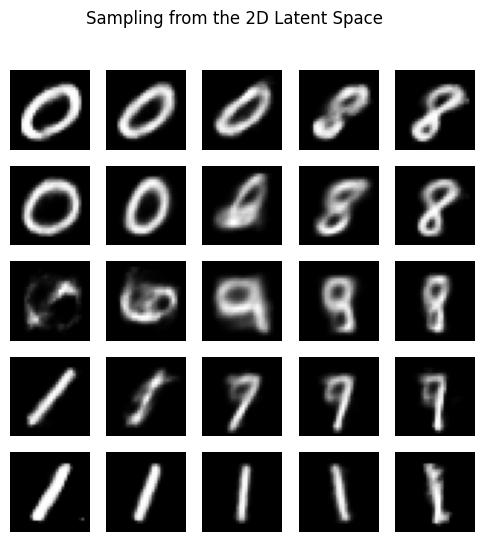

In [12]:
def sample_latent_grid():
    model.eval()
    n = 5
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)

    plt.figure(figsize=(6, 6))

    with torch.no_grad():
        for i, y in enumerate(grid_y):
            for j, x in enumerate(grid_x):
                z = torch.tensor([[x, y]], dtype=torch.float32).to(device)
                x_hat = model.decode(z)[0, 0].cpu().numpy()
                plt.subplot(n, n, i*n + j + 1)
                plt.imshow(x_hat, cmap="gray")
                plt.axis("off")

    plt.suptitle("Sampling from the 2D Latent Space")
    plt.show()

sample_latent_grid()

## Collect latent space per epoch

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, exp

def collect_latent_samples(model, data_loader, num_batches=50, use_mu=True):
    """
    Go through a few batches and collect latent vectors z (or mu).
    - use_mu=True: use the mean μ(x) of q(z|x)
    - use_mu=False: sample z via reparameterization
    """
    model.eval()
    zs = []

    with torch.no_grad():
        for i, (x, _) in enumerate(data_loader):
            if i >= num_batches:
                break
            x = x.to(device)
            mu, logvar = model.encode(x)
            if use_mu:
                z = mu
            else:
                # sample z = mu + sigma * eps
                std = torch.exp(0.5 * logvar)
                eps = torch.randn_like(std)
                z = mu + std * eps
            zs.append(z.cpu().numpy())

    if len(zs) == 0:
        return None

    zs = np.concatenate(zs, axis=0)   # shape [N, latent_dim]
    return zs

## Plot latent distribution vs Gaussian

In [15]:
def normal_pdf(x):
    # PDF of N(0,1)
    return (1.0 / sqrt(2 * pi)) * np.exp(-0.5 * x**2)

def plot_latent_hist(z_samples, epoch, bins=40):
    """
    z_samples: numpy array [N, 2]
    Plots:
      - Histogram of z1 and z2
      - Overlaid standard normal PDF
    """
    if z_samples is None:
        print("No latent samples to plot.")
        return

    z1 = z_samples[:, 0]
    z2 = z_samples[:, 1]

    mean_z1, std_z1 = np.mean(z1), np.std(z1)
    mean_z2, std_z2 = np.mean(z2), np.std(z2)

    print(f"[Epoch {epoch}] z1 mean={mean_z1:.3f}, std={std_z1:.3f} | "
          f"z2 mean={mean_z2:.3f}, std={std_z2:.3f}")

    xs = np.linspace(-4, 4, 400)
    pdf = normal_pdf(xs)

    plt.figure(figsize=(12, 4))

    # z1 histogram
    plt.subplot(1, 3, 1)
    plt.hist(z1, bins=bins, density=True, alpha=0.6)
    plt.plot(xs, pdf, linewidth=2)
    plt.title(f"z1 distribution (epoch {epoch})")
    plt.xlabel("z1")
    plt.ylabel("density")

    # z2 histogram
    plt.subplot(1, 3, 2)
    plt.hist(z2, bins=bins, density=True, alpha=0.6)
    plt.plot(xs, pdf, linewidth=2)
    plt.title(f"z2 distribution (epoch {epoch})")
    plt.xlabel("z2")
    plt.ylabel("density")

    # 2D scatter
    plt.subplot(1, 3, 3)
    plt.scatter(z1, z2, s=4, alpha=0.5)
    plt.title("2D latent scatter")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

    plt.tight_layout()
    plt.show()

## Train + monitor latent Gaussianity over epochs

Epoch 01 | Loss 146.4660 | Recon 140.1961 | KL 6.2700
[Test] Loss 150.4879 | Recon 144.3132 | KL 6.1747
[Epoch 1] z1 mean=0.316, std=1.145 | z2 mean=0.091, std=1.223


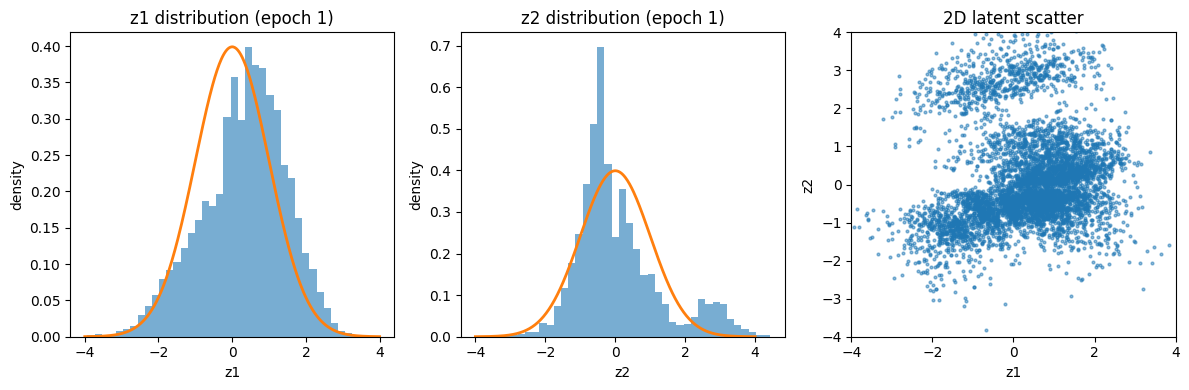

Epoch 02 | Loss 146.4281 | Recon 140.1427 | KL 6.2854
[Test] Loss 150.2136 | Recon 143.9594 | KL 6.2541
[Epoch 2] z1 mean=0.294, std=1.125 | z2 mean=0.091, std=1.218


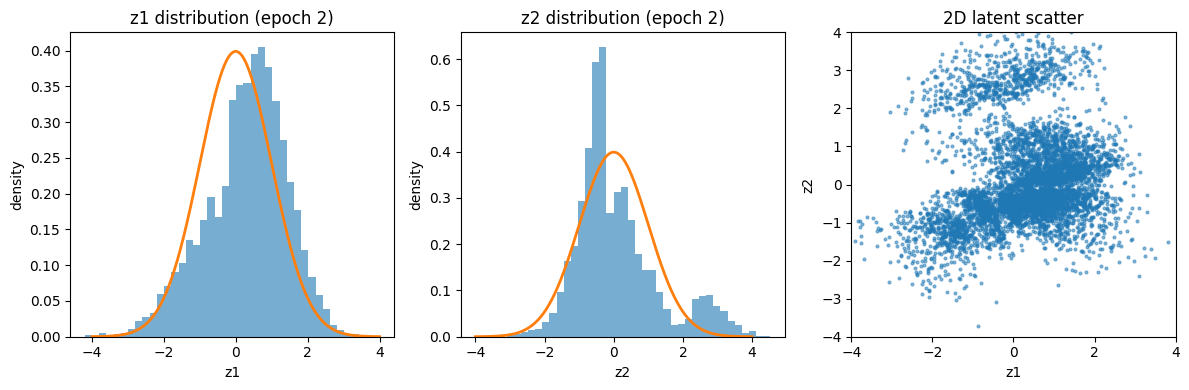

Epoch 03 | Loss 146.3028 | Recon 140.0112 | KL 6.2916
[Test] Loss 150.1769 | Recon 144.0339 | KL 6.1430
[Epoch 3] z1 mean=0.325, std=1.144 | z2 mean=0.096, std=1.192


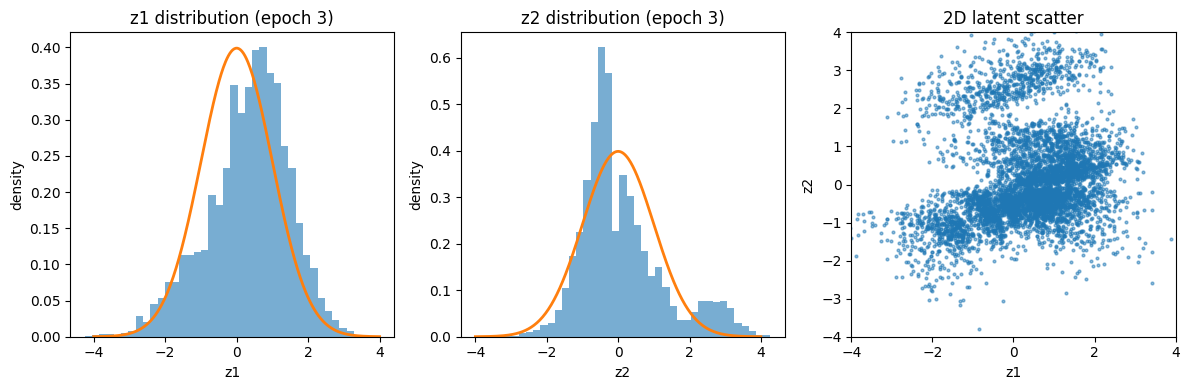

Epoch 04 | Loss 146.2669 | Recon 139.9795 | KL 6.2875
[Test] Loss 150.3898 | Recon 144.1125 | KL 6.2774
[Epoch 4] z1 mean=0.337, std=1.166 | z2 mean=0.066, std=1.195


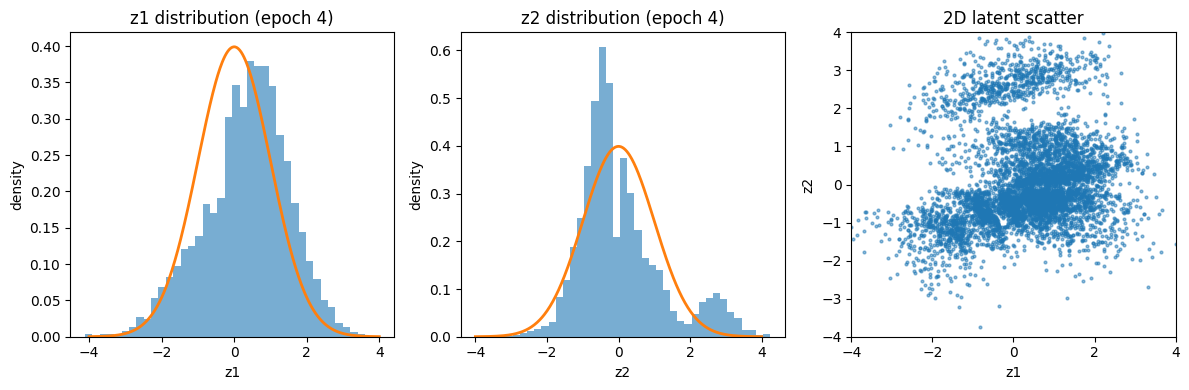

Epoch 05 | Loss 146.1133 | Recon 139.8181 | KL 6.2952
[Test] Loss 150.3900 | Recon 144.1909 | KL 6.1991
[Epoch 5] z1 mean=0.309, std=1.134 | z2 mean=0.077, std=1.196


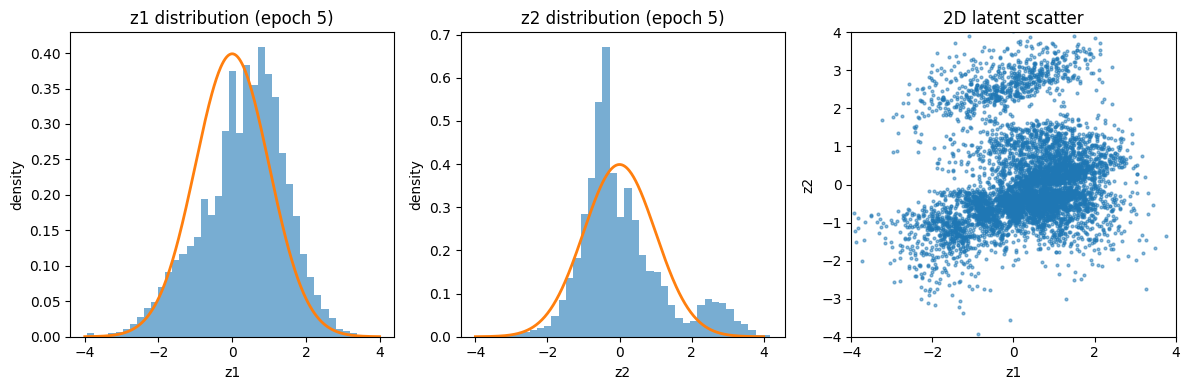

Epoch 06 | Loss 145.9981 | Recon 139.6952 | KL 6.3030
[Test] Loss 150.0817 | Recon 143.6359 | KL 6.4458
[Epoch 6] z1 mean=0.296, std=1.129 | z2 mean=0.086, std=1.223


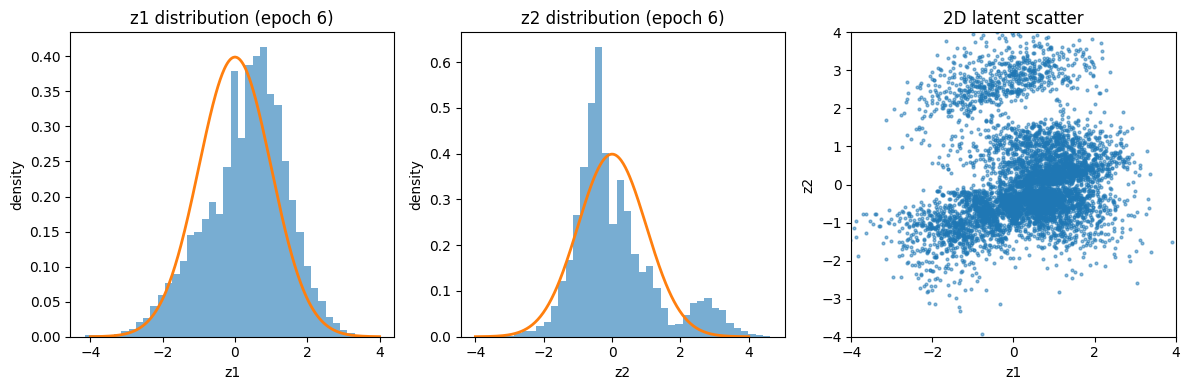

Epoch 07 | Loss 145.9161 | Recon 139.6133 | KL 6.3028
[Test] Loss 151.3732 | Recon 145.1521 | KL 6.2212
[Epoch 7] z1 mean=0.277, std=1.159 | z2 mean=0.126, std=1.205


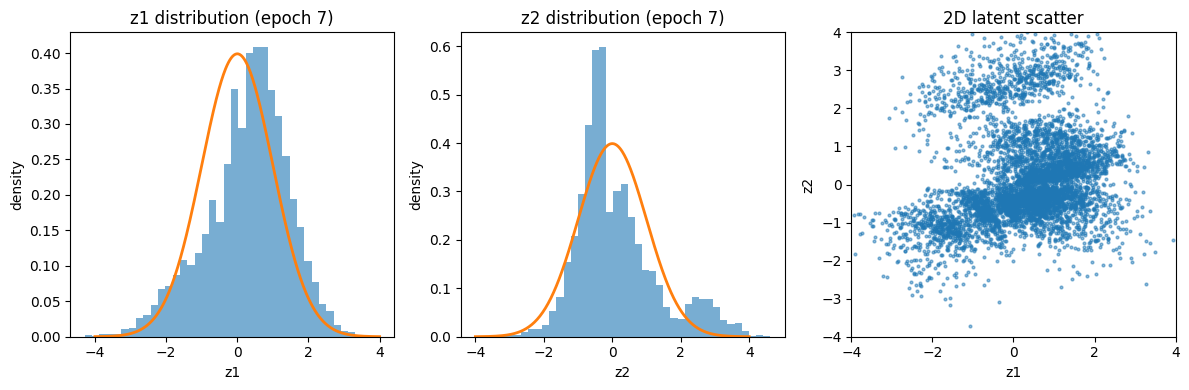

In [17]:
latent_stats = {
    "epoch": [],
    "mean_z1": [],
    "std_z1": [],
    "mean_z2": [],
    "std_z2": [],
}

num_epochs = 7  
num_batches_for_latent = 50

for epoch in range(1, num_epochs + 1):
    train_epoch(epoch)
    test_epoch(epoch)

    # collect latent samples from test set (you can switch to train_loader)
    z_samples = collect_latent_samples(model, test_loader,
                                       num_batches=num_batches_for_latent,
                                       use_mu=True)  # or False for sampled z

    if z_samples is not None:
        z1 = z_samples[:, 0]
        z2 = z_samples[:, 1]
        m1, s1 = np.mean(z1), np.std(z1)
        m2, s2 = np.mean(z2), np.std(z2)

        latent_stats["epoch"].append(epoch)
        latent_stats["mean_z1"].append(m1)
        latent_stats["std_z1"].append(s1)
        latent_stats["mean_z2"].append(m2)
        latent_stats["std_z2"].append(s2)

        # Visual inspection each epoch
        plot_latent_hist(z_samples, epoch)